In [1]:
import sys
sys.path.insert(0,"/mnt/lustre3p/users/kkoech/.local")
#sys.path.append("./mrcnn")

In [2]:
import os
os.chdir("./")

In [5]:
import tensorflow as tf
print(tf.__version__)
print(tf.__file__)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=10,inter_op_parallelism_threads=10)
sess = tf.compat.v1.Session(config=session_conf) 

2.5.0
/mnt/lustre3p/users/kkoech/.local/tensorflow/__init__.py


In [6]:
# !pip uninstall -y tensorflow
# !pip uninstall -y tensorflow-gpu

In [7]:
# !pip install --target="/mnt/lustre3p/users/kkoech/.local" tensorflow
# !pip install --target="/mnt/lustre3p/users/kkoech/.local" tensorflow-gpu

In [45]:
# Set matplotlib backend so that figures are saved on background
import matplotlib
# matplotlib.use("Agg")
%matplotlib inline

# Import necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout,Flatten,Input,Dense, BatchNormalization
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
from matplotlib import pyplot as plt
import numpy as np
import cv2
import argparse
import pickle
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.models import load_model
import datetime
import random
import json
import collections
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set(font_scale=1.0)
import pandas as pd
from tqdm import tqdm
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [46]:
# !pip3 install --target="/mnt/lustre3p/users/kkoech/.local" tensorflow-gpu

In [47]:
dataset = "images/"
model = "models/"

In [48]:
labels_list = [i for i in os.listdir(dataset)]
print(labels_list)
print(len(labels_list))

['giraffe', 'baboon', 'lion', 'bears', 'rhino', 'bird', 'hare', 'tiger', 'deer', 'cheetah', 'zebra', 'hippo', 'leopard', 'elephants', 'antelope']
15


In [49]:
all_details = []
for index, name in tqdm(enumerate(labels_list)):
    if os.path.exists("data_as_array/{}.npy".format(name)):
        continue
    print(name)
    files_in_folder = list(paths.list_images(os.path.join(dataset,name)))
    folder_data = []
    for index1, file1 in enumerate(files_in_folder):
        data_point = {}
        # extract label from image path
        label = file1.split(os.path.sep)[-2]
        # interested in only three classes, so, we skip the rest
        if label not in labels_list:
            continue
        # append the label to labels
        # labels.append([label])
        # load image, convert to RGB, resize to
        # 299-d 
        print(index1, file1)
        try:
            image = cv2.imread(file1)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (299,299))
        except:
            print("error")
            continue
        # append image to image_data
        #image_data.append(image)
        data_point = {
            "image":image,
            "label": label
        }
        folder_data.append(data_point)
    category_data = np.array(folder_data)
    if not os.path.exists("data_as_array/{}.npy".format(name)):
        np.save("data_as_array/{}.npy".format(name),folder_data, allow_pickle=True)
    all_details.append(folder_data)


15it [00:00, 5029.14it/s]


In [50]:
data1 = []
for file1 in os.listdir("data_as_array"):
    data2 = np.load(os.path.join("data_as_array",file1), allow_pickle=True).tolist()
    data1.append(data2)
data1 = np.array(data1,dtype=object)

baboon


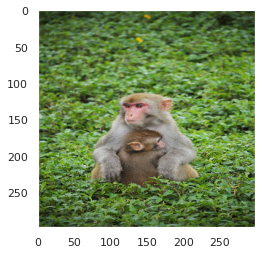

In [51]:
num = random.choice(np.arange(0,len(data1)))
print(data1[num][0]["label"])
plt.imshow(data1[num][0]["image"]);
plt.grid(None)
plt.show()

In [52]:
def train_val_test_split(data, subset_labels, display_proportions=True):
    # all labels
    all_labels = [i[0]["label"] for i in data if len(i)!=0]
    assert set(np.intersect1d(subset_labels, all_labels))==set(subset_labels),\
    "Wrong label given in subset_labels. Possible values: {}".format(all_labels)
    # encoder object
    global lb
    lb = LabelBinarizer()
    # Filter classes
    class_filtered = []
    train_data = []
    val_data = []
    test_data = []
    for index, elem in enumerate(data):
        if not elem:
            continue
        label = elem[0]["label"]
        if label not in subset_labels:
            continue
        train_class1, val_class1, test_class1 = \
              np.split(elem, 
                       [int(0.6*len(elem)), int(0.8*len(elem))])
        train_data.extend(list(train_class1))
        val_data.extend(list(val_class1))
        test_data.extend(list(test_class1))
        
    X_train, y_train = np.array([i["image"] for i in train_data]),\
    lb.fit_transform(np.array([j["label"] for j in train_data]))

    X_val, y_val = np.array([i["image"] for i in val_data]), \
    lb.fit_transform(np.array([j["label"] for j in val_data]))

    X_test, y_test = np.array([i["image"] for i in test_data]),\
    lb.fit_transform(np.array([j["label"] for j in test_data]))

    if display_proportions == True:
        train_dist = dict(collections.Counter([j["label"] for j in train_data]))
        print("For training", json.dumps(train_dist, indent=3))
        val_dist = dict(collections.Counter([j["label"] for j in val_data]))
        print("For validation", json.dumps(val_dist, indent=3))
        test_dist = dict(collections.Counter([j["label"] for j in test_data]))
        print("For testing", json.dumps(test_dist, indent=3))
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)



In [53]:
# Because of possible computation limitations you can train the model(s)
# on the subset of data like we do here
subset_labels1 = ['antelope', 'baboon', 'bears', 'bird', \
                   'elephants', 'giraffe', 'hare', 'hippo', \
                  'leopard', 'lion', 'rhino', 'zebra']
(X_train, y_train), (X_val, y_val), (X_test, y_test) = \
train_val_test_split(data=data1,subset_labels=subset_labels1)

For training {
   "giraffe": 435,
   "leopard": 344,
   "bird": 557,
   "baboon": 603,
   "hare": 196,
   "elephants": 678,
   "hippo": 60,
   "rhino": 217,
   "antelope": 583,
   "bears": 318,
   "zebra": 300,
   "lion": 418
}
For validation {
   "giraffe": 145,
   "leopard": 115,
   "bird": 186,
   "baboon": 201,
   "hare": 65,
   "elephants": 226,
   "hippo": 20,
   "rhino": 73,
   "antelope": 195,
   "bears": 106,
   "zebra": 100,
   "lion": 139
}
For testing {
   "giraffe": 146,
   "leopard": 115,
   "bird": 186,
   "baboon": 201,
   "hare": 66,
   "elephants": 227,
   "hippo": 21,
   "rhino": 73,
   "antelope": 195,
   "bears": 106,
   "zebra": 100,
   "lion": 140
}


In [101]:
class SpeciesModelTrain(object):
    
    def __init__(self, model_path, logs_path, resume=False):
        self.model_path = model_path
        self.logs_path = logs_path
        self.resume = resume

    def get_modePath(self):
        if self.resume == True:
            from pathlib import Path
            model_dir = sorted(Path(self.model_path).iterdir(), key=os.path.getmtime)[-1]
            print(model_dir)
            if not os.path.exists(model_dir) or os.path.isdir(model_dir)==False:
                model_dir = os.path.join(self.model_path,datetime.datetime.now().strftime("%m%d%Y-%H%M%S"))
                # We need to make this directory explicitly unline in logdir in Tensorboard callback
                os.makedirs(model_dir)
                return model_dir
            return model_dir
        else:
            model_dir = os.path.join(self.model_path,datetime.datetime.now().strftime("%m%d%Y-%H%M%S"))
            # We need to make this directory explicitly unline in logdir in Tensorboard callback
            os.makedirs(model_dir)
            return model_dir

    def get_logsPath(self):
        if self.resume==True:
            from pathlib import Path
            log_dir = sorted(Path(self.logs_path).iterdir(), key=os.path.getmtime)[-1]
            print(log_dir)
            return log_dir
        else:
            # tensorboard will make this logs_path automatically
            log_dir = os.path.join(self.logs_path,datetime.datetime.now().strftime("%m%d%Y-%H%M%S"))
            return log_dir

    def setCallbacks(self):
      
        # Model callbacks

        # Checkpoint - save the model at an epoch whenever there's an improvment in val_los
        # in relation to previous epoch
        model_checkpoint = ModelCheckpoint(
            filepath=os.path.join(self.get_modePath(),"model_{epoch:02d}-{val_loss:.2f}.h5"), monitor='val_loss',\
            verbose=1, save_best_only=True,save_weights_only=False, \
            mode='auto', save_freq='epoch'
        )

        # Stop training if the model is no longer improving
        early_stopping = EarlyStopping(
            monitor='val_loss', min_delta=0, patience=10, verbose=1,
            mode='auto', baseline=None, restore_best_weights=False
        )

        # Log the training stats into a tensorbord 
    
        tensorboard = TensorBoard(
            log_dir=self.get_logsPath(), histogram_freq=0, write_graph=True,
            write_images=False, update_freq='epoch', profile_batch=2,
            embeddings_freq=0, embeddings_metadata=None
        )

        # list of all the three call backs
        callbacks = [model_checkpoint, early_stopping, tensorboard]
        return callbacks

    def train(self, binarizer, epochs, lr=1e-4, resume_path=None):
        # initialize the training data augmentation object
        trainAug = ImageDataGenerator(
            rotation_range=30,
            zoom_range=0.15,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.15,
            horizontal_flip=True,
            fill_mode="nearest")
        # initialize the validation/testing data augmentation object (which
        # we'll be adding mean subtraction to)
        valAug = ImageDataGenerator()
        if self.resume == True:
            if resume_path  is None:
                from pathlib import Path
                assert len(os.listdir(self.model_path))>0,\
                "Training cannot be resumed because there's no saved model checkpoint. set resume to False"
                model_dir1 = sorted(Path(self.model_path).iterdir(), key=os.path.getmtime)[-1]
                assert os.path.isdir(model_dir1),\
                "Training cannot be resumed because there's no saved model checkpoint. set resume to False"
                    
                resume_path = sorted(Path(model_dir1).iterdir(), key=os.path.getmtime)[-1]
               
            loaded_model = load_model(resume_path)
            # retraining the model
            initial_epoch= int(str(resume_path).split("model_")[-1].split("-")[0])
            assert epochs>=initial_epoch,"epochs must be greater than or equals to initial epoch. Choice any value above {}".format(initial_epoch)
            # train the head of the network for a few epochs (all other layers
            # are frozen) -- this will allow the new FC layers to start to become
            # initialized with actual "learned" values versus pure random
            print("[INFO] training head...")
            H = loaded_model.fit(
                x=trainAug.flow(X_train, y_train, batch_size=32),
                validation_data=valAug.flow(X_val, y_val),
                epochs=epochs, callbacks=[self.setCallbacks()], initial_epoch=initial_epoch)

        elif self.resume == False:
            # load pre-trained model graph, don't add final layer i.e include_top=False
            base_model = InceptionV3(
                include_top=False,
                weights="imagenet",
                input_tensor=None,
                input_shape=(299,299,3),
            )

            # add global pooling just like in InceptionV3
            new_output = GlobalAveragePooling2D()(base_model.output)
            new_output = Dense(len(binarizer.classes_), activation='softmax')(new_output)
            model = Model(base_model.inputs, new_output)
            
            # set all layers trainable by default
            for layer in model.layers:
                layer.trainable = True
                if isinstance(layer, BatchNormalization):
                    # we do aggressive exponential smoothing of batch norm
                    # parameters to faster adjust to our new dataset
                    layer.momentum = 0.7

            # fix deep layers (fine-tuning only last 50)
            for layer in model.layers[:-50]:
                # fix all but batch norm layers, because we need to update moving averages for a new dataset!
                if not isinstance(layer, BatchNormalization):
                    layer.trainable = False
            # compile our model (this needs to be done after our setting our
            # layers to being non-trainable)
            print("[INFO] compiling model...")
            opt = SGD(learning_rate=lr, momentum=0.9, decay=1e-4/epochs)
            model.compile(loss="categorical_crossentropy", optimizer=opt,
                metrics=["accuracy"])
            

            # train the head of the network for a few epochs (all other layers
            # are frozen) -- this will allow the new FC layers to start to become
            # initialized with actual "learned" values versus pure random
            print("[INFO] traini4/1AY0e-g6M3r-Y3fNHUKOAg5T0SlL_jmwbnFDKhjOklIUz1loS6Y0liW2OHYQng head...")
            H = model.fit(
                x=trainAug.flow(X_train, y_train, batch_size=32),
                validation_data=valAug.flow(X_val, y_val),
                epochs=epochs, callbacks=[self.setCallbacks()], initial_epoch=0)

            return model

lr_value = 1e-4
s = SpeciesModelTrain(model_path=model_path, 
                     logs_path=logs_path,
                     resume=True)
s.train(binarizer=lb, epochs=100)

In [102]:
class SpeciesModelEvaluation(object):
    
    def __init__(self,models_path):
        self.models_path = models_path
        
    def Evaluation(self,set1="test", saved_model=None,save_to="output"):
        assert set1 in ["train","val","test"],\
        "set1 can take take only one of the the following values ['train','val','test']"
       
        if saved_model is None:
            # path to the saved model is not given get the path to the latest saved model.
            from pathlib import Path
            model_dir1 = sorted(Path(self.models_path).iterdir(), key=os.path.getmtime)[-1]
            assert os.path.isdir(model_dir1) and len(os.listdir(model_dir1))>0,\
            "No model saved in the following path {}".format(model_dir1)
                
            saved_model = sorted(Path(model_dir1).iterdir(), key=os.path.getmtime)[-1]

        loaded_model = load_model(saved_model)
        
        if set1=="train":
            predictions = loaded_model.predict(x=X_train.astype("float32"), batch_size=32, verbose=1)
            y_truth = y_train.argmax(axis=1)
            
        elif set1=="val":
            predictions = loaded_model.predict(x=X_val.astype("float32"), batch_size=32, verbose=1)
            y_truth = y_val.argmax(axis=1)
            
        else:
            predictions = loaded_model.predict(x=X_test.astype("float32"), batch_size=32, verbose=1)
            y_truth = y_test.argmax(axis=1)
            
        y_pred = predictions.argmax(axis=1)
        
        print("[INFO] Confusion matrix for {} set.".format(set1))
        cm = confusion_matrix(y_truth,y_pred)
        print(cm)
        
        df_cm = pd.DataFrame(cm, index = ["Actual-"+i for i in lb.classes_],
                  columns = ["Predict-"+i for i in lb.classes_])
        group_counts = ["{0:0.0f}".format(value) for value in
                        cm.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in
                                cm.flatten()/np.sum(cm)]

        labels = [f"{v1}\n{v2}" for v1, v2 in
                    zip(group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(len(subset_labels1),len(subset_labels1))
        
        plt.figure(figsize=(15,12))
        plt.title("Confusion matrix for {} set.".format(set1))
        plt.xlabel("Predictions")
        plt.ylabel("Actual")
        sns.heatmap(df_cm,annot=labels,fmt='')
        plt.savefig("output/confusion_matrix_{}.png".format(set1))
        plt.show()
    
        print("[INFO] Classification Report for {} set.".format(set1))
        results_dict = classification_report(y_truth, y_pred,
                                             output_dict=True,
                                             target_names=lb.classes_)
        with open("output/confusion_matrix_{}.json".format(set1), "w+") as f:
            json.dump(results_dict, f, indent=3)
        print(json.dumps(results_dict,indent=3))
        
        return loaded_model, cm, results_dict

model_path = './models'
logs_path = "./logs"



50/50 [==============================] - 25s 473ms/step
[INFO] Confusion matrix for test set.
[[186   0   0   2   3   2   2   0   0   0   0   0]
 [  0 193   2   1   3   0   1   0   0   1   0   0]
 [  1   3  96   2   1   1   0   0   0   2   0   0]
 [  1   0   0 185   0   0   0   0   0   0   0   0]
 [  2   0   0   0 222   1   0   1   0   0   1   0]
 [  6   1   2   3   2 129   0   0   1   0   0   2]
 [  2   1   2   4   1   0  53   0   0   3   0   0]
 [  0   0   1   2   1   0   0  14   0   0   3   0]
 [  0   0   0   0   1   4   0   0 107   0   0   3]
 [  3   1   0   1   2   1   0   0   2 129   0   1]
 [  0   0   1   1   4   0   0   0   0   0  67   0]
 [  2   0   1   0   2   4   1   0   0   1   0  89]]


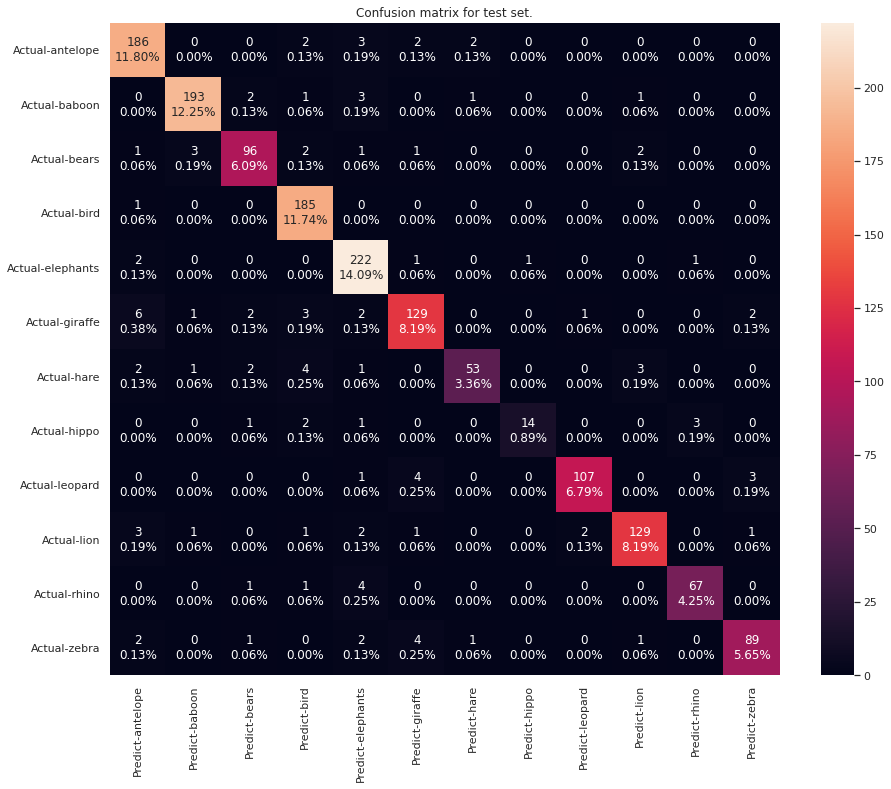

[INFO] Classification Report for test set.
{
   "antelope": {
      "precision": 0.916256157635468,
      "recall": 0.9538461538461539,
      "f1-score": 0.9346733668341708,
      "support": 195
   },
   "baboon": {
      "precision": 0.9698492462311558,
      "recall": 0.9601990049751243,
      "f1-score": 0.965,
      "support": 201
   },
   "bears": {
      "precision": 0.9142857142857143,
      "recall": 0.9056603773584906,
      "f1-score": 0.909952606635071,
      "support": 106
   },
   "bird": {
      "precision": 0.9203980099502488,
      "recall": 0.9946236559139785,
      "f1-score": 0.9560723514211887,
      "support": 186
   },
   "elephants": {
      "precision": 0.9173553719008265,
      "recall": 0.9779735682819384,
      "f1-score": 0.9466950959488273,
      "support": 227
   },
   "giraffe": {
      "precision": 0.9084507042253521,
      "recall": 0.8835616438356164,
      "f1-score": 0.8958333333333333,
      "support": 146
   },
   "hare": {
      "precision": 0.929

In [111]:
ss = SpeciesModelEvaluation(models_path=model_path)
loaded_model, _, _ = ss.Evaluation(set1="test")

In [ ]:
#Failed cases

In [107]:
predictions = loaded_model.predict(x=X_val.astype("float32"), batch_size=32)
y_pred = predictions.argmax(axis=1)
y_truth = y_test.argmax(axis=1)

In [108]:
predictions[0]

array([8.9480011e-05, 1.7858161e-04, 5.4914264e-05, 1.7871519e-04,
       6.8464607e-05, 9.8157585e-01, 1.4911877e-04, 1.4646952e-05,
       1.6976405e-02, 7.5705757e-05, 1.1484558e-05, 6.2680390e-04],
      dtype=float32)

Pred: leopard 0.99938464
Tuth: giraffe


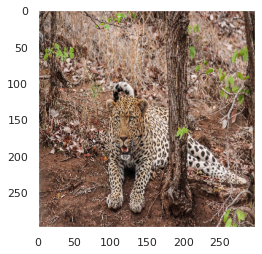

Pred: antelope 0.6382593
Tuth: giraffe


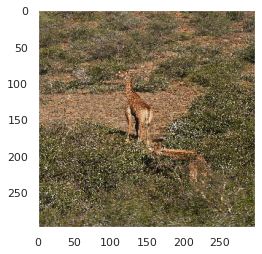

Pred: baboon 0.88898754
Tuth: giraffe


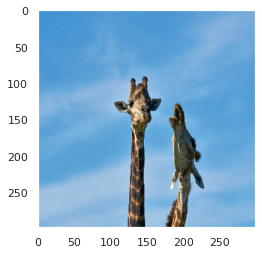

Pred: leopard 0.9788012
Tuth: giraffe


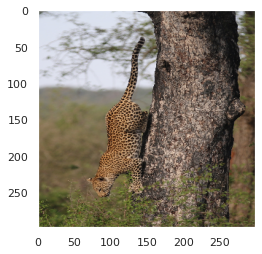

Pred: bird 0.7915705
Tuth: giraffe


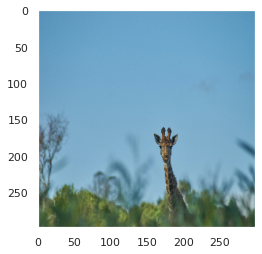

Pred: elephants 0.34922814
Tuth: giraffe


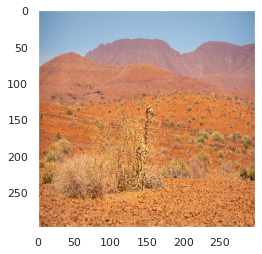

Pred: antelope 0.5191277
Tuth: giraffe


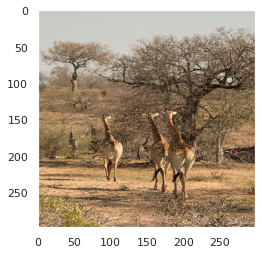

Pred: antelope 0.9754847
Tuth: giraffe


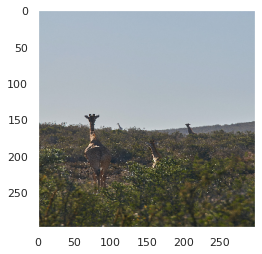

Pred: antelope 0.9754847
Tuth: giraffe


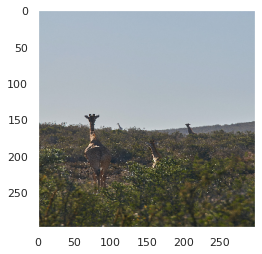

Pred: leopard 0.5754317
Tuth: giraffe


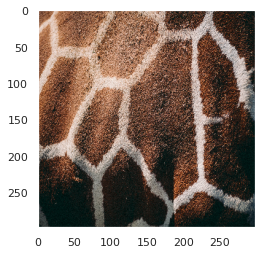

In [109]:
# failed cases - are they difficult?
case = 0
for index, (truth, pred) in enumerate(zip(y_truth, y_pred)):
    if case == 10:
        break
    if truth!=pred:
        print('Pred:',lb.classes_[pred],predictions[index][pred])
        print('Tuth:',lb.classes_[truth])
        plt.imshow(X_val[index])
        plt.grid(b=None)
        plt.show()
        case += 1
        

In [86]:
# # Load the TensorBoard notebook extension
# %load_ext tensorboard

In [87]:
# %tensorboard --logdir="logs"